In [1]:
from pathlib import Path; import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent); os.chdir(set_path)

In [2]:
import tensorflow as tf
#tf.config.run_functions_eagerly(True)
from Utils.load_data import x_train, x_test, train_ds, test_ds, image_dim, y_test
from Inverse_Autoregressive_Flow.IAF_VAE import IAF_VAE
import matplotlib.pyplot as plt
import datetime

import numpy as np
import matplotlib as mpl

In [21]:
latent_representation_dim = 2
EPOCHS = 10
name = ""
# Define vae
IAF_vae = IAF_VAE(latent_representation_dim, image_dim, layer_nodes=256, n_autoregressive_units=6)

In [22]:
samples = x_test[0:9, :, :, :][:, :, :]
example_reconstruction_hist = [IAF_vae(samples)[0].numpy()]

# Tensorboard writer
logdir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_file_writer = tf.summary.create_file_writer(logdir + name +  "/train/")
test_file_writer = tf.summary.create_file_writer(logdir + name + "/test")


train_history = []
test_history = []
step_counter = 0
tf.summary.experimental.set_step(step_counter)
for epoch in range(EPOCHS):
    total_train_loss = 0
    for images in train_ds:
        ELBO, log_prob_x_given_z_decode_batch, log_probs_z_given_x_batch, log_prob_z_prior_batch = IAF_vae.train_step(images)
        total_train_loss -= ELBO
        with train_file_writer.as_default():
            tf.summary.scalar("ELBO", ELBO)
            tf.summary.scalar("log_prob_x_given_z_decode", log_prob_x_given_z_decode_batch)
            tf.summary.scalar("log_probs_z_given_x", log_probs_z_given_x_batch)
            tf.summary.scalar("log_probs_z_given_x", log_probs_z_given_x_batch)
            tf.summary.scalar("log_prob_z_prior", log_prob_z_prior_batch)
        step_counter += 1
        tf.summary.experimental.set_step(step_counter)

    total_test_loss = 0
    for test_images in test_ds:
        ELBO, log_prob_x_given_z_decode_batch, log_probs_z_given_x_batch, log_prob_z_prior_batch = IAF_vae.test_step(test_images)
        total_test_loss -= ELBO
        with test_file_writer.as_default():
            tf.summary.scalar("ELBO", ELBO)
            tf.summary.scalar("log_prob_x_given_z_decode", log_prob_x_given_z_decode_batch)
            tf.summary.scalar("log_probs_z_given_x", log_probs_z_given_x_batch)
            tf.summary.scalar("log_probs_z_given_x", log_probs_z_given_x_batch)
            tf.summary.scalar("log_prob_z_prior", log_prob_z_prior_batch)

    train_history.append(total_train_loss / len(train_ds))
    test_history.append(total_test_loss / len(test_ds))
    example_reconstruction_hist.append(IAF_vae(samples)[0].numpy())

    print(
        f'Epoch {epoch + 1}, '
        f'\n Loss: {total_train_loss.numpy() / len(train_ds)}, '
        f'\n Test Loss: {total_test_loss.numpy() / len(test_ds)}')

Epoch 1, 
 Loss: 218.06447805851064, 
 Test Loss: 188.5740234375
Epoch 2, 
 Loss: 185.8831283244681, 
 Test Loss: 182.4326416015625
Epoch 3, 
 Loss: 174.78279587765957, 
 Test Loss: 166.9887939453125
Epoch 4, 
 Loss: 162.92247340425533, 
 Test Loss: 160.19288330078126
Epoch 5, 
 Loss: 158.68048537234043, 
 Test Loss: 156.92635498046874
Epoch 6, 
 Loss: 156.07436835106384, 
 Test Loss: 155.21461181640626
Epoch 7, 
 Loss: 155.0940824468085, 
 Test Loss: 153.8427490234375
Epoch 8, 
 Loss: 152.97262300531915, 
 Test Loss: 152.14940185546874
Epoch 9, 
 Loss: 152.58199800531915, 
 Test Loss: 151.29259033203124
Epoch 10, 
 Loss: 151.36349734042554, 
 Test Loss: 150.947900390625


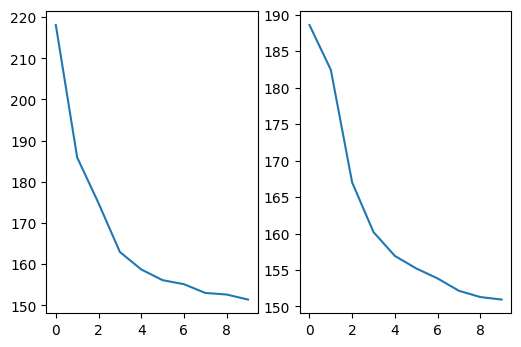

In [23]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(train_history)
axs[1].plot(test_history)
plt.show()

# Visualise Predictions

### original

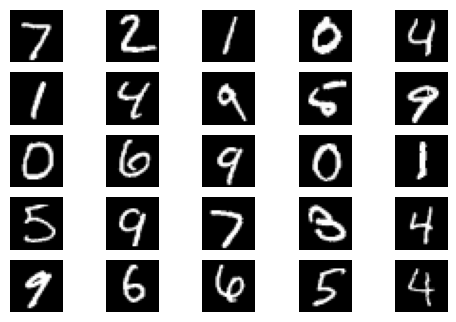

In [24]:
n = 5
fig, axs = plt.subplots(n,n)
for i in range(n*n):
    row = int(i/n)
    col = i % n
    axs[row, col].imshow(x_test[i, :, :], cmap="gray")
    axs[row, col].axis('off')

### Predicted

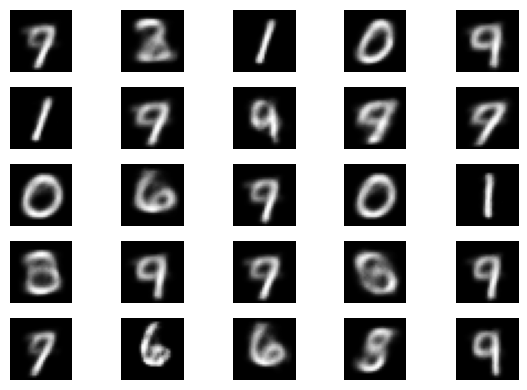

In [25]:
n = 5
reconstruction= IAF_vae(x_test[0:n*n, :, :])[0]
reconstruction = tf.nn.sigmoid(reconstruction)
fig, axs = plt.subplots(n,n)
for i in range(n*n):
    row = int(i/n)
    col = i % n
    axs[row, col].imshow(reconstruction[i, :, :], cmap="gray")
    axs[row, col].axis('off')
fig.tight_layout()

### If we want to compare history across training

In [26]:
"""
fig, axs = plt.subplots(3,3)
for i in range(9):
    row = int(i/3)
    col = i % 3
    axs[row, col].imshow(samples[i, :, :], cmap="gray")
    axs[row, col].axis('off')

n = -1
fig, axs = plt.subplots(3, 3)
for i in range(9):
    row = int(i / 3)
    col = i % 3
    axs[row, col].imshow(np.exp(example_reconstruction_hist[n][i, :, :]), cmap="gray")
    axs[row, col].axis('off')
""" 
None

# Visualise encoding in 2D

Text(0.5, 1.0, 'p(z | x)')

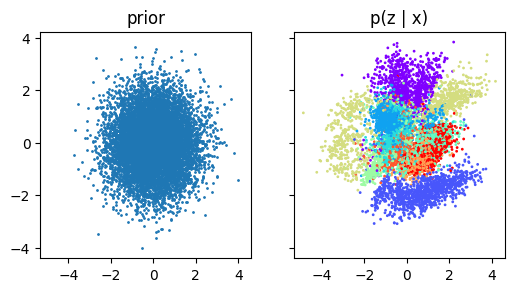

In [27]:
mpl.rcParams['figure.dpi'] = 100
encoding_2D = IAF_vae.get_encoding(x_test)
fig, axs = plt.subplots(1,2, figsize=(6,3), sharex=True, sharey=True)
axs[1].scatter(encoding_2D[:, 0], encoding_2D[:, 1], c=y_test, s=1, cmap=mpl.cm.rainbow)
#plt.colorbar()
prior = np.random.standard_normal((10000, 2))
axs[0].scatter(prior[:, 0], prior[:, 1], s=1)

axs[0].set_title("prior")
axs[1].set_title("p(z | x)")

# Display a 2D manifold of the digits

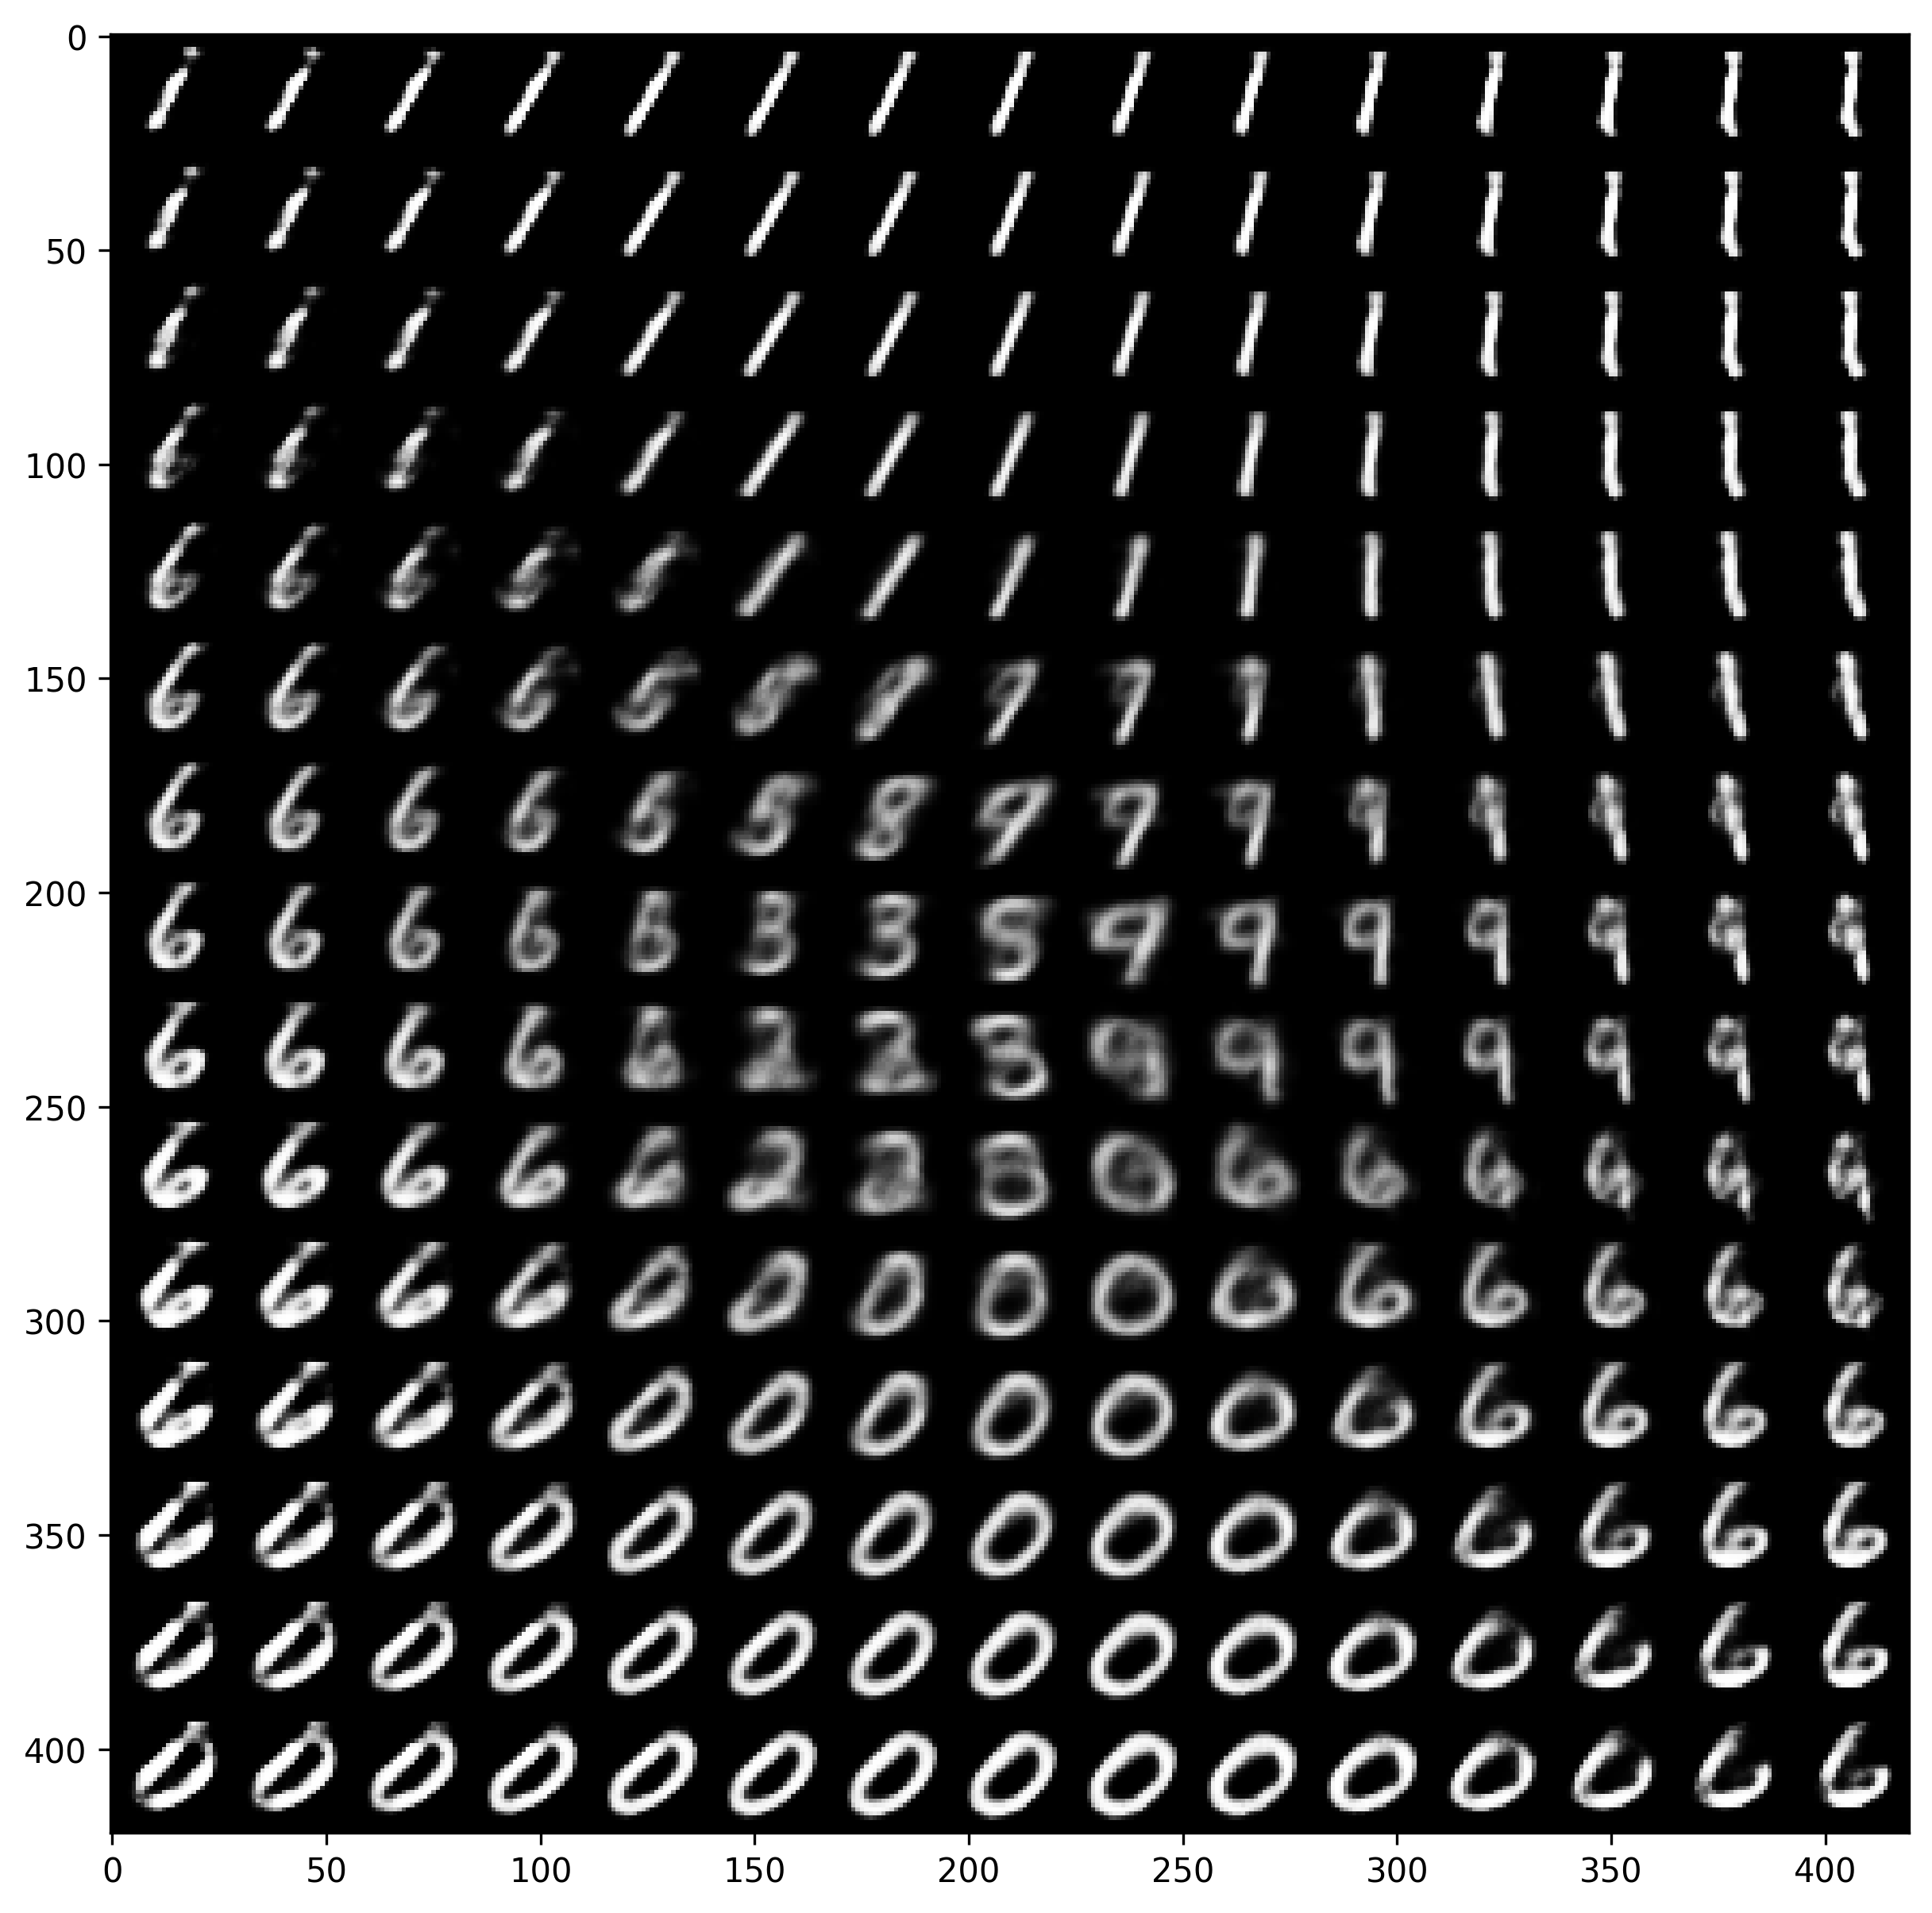

In [28]:
mpl.rcParams['figure.dpi'] = 300
n = 15  # figure with 15x15 digits
half_range = 4
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-half_range, half_range, n)
grid_y = np.linspace(-half_range, half_range, n)
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = tf.nn.sigmoid(IAF_vae.decoder(z_sample).numpy()[0]).numpy()
        digit = x_decoded.reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap="gray")

# Let's look at 4 digits

In [29]:
### First comfirm the digits are different

In [30]:
y_test[0:4]

array([[7.],
       [2.],
       [1.],
       [0.]], dtype=float32)

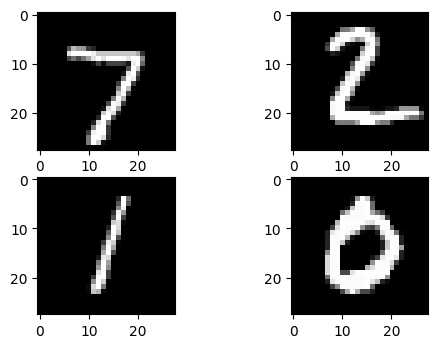

In [31]:
mpl.rcParams['figure.dpi'] = 100
fig, axs = plt.subplots(2,2)
for i in range(4):
    row = int(i/2)
    col = i % 2
    axs[row, col].imshow(x_test[i, :, :], cmap="gray")

# We want to see some bendy shapes here!

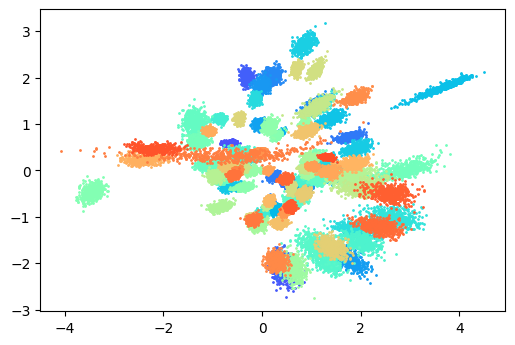

In [32]:
n_points = 100
cols = cmap=mpl.cm.rainbow(np.linspace(0.1, 0.9, n_points))
points = []
for point_n in range(n_points):
    point_repeat = np.zeros((500, 28, 28, 1))
    point_repeat[: :, :, :] = x_test[point_n, :, :]
    encoding_2D = IAF_vae.get_encoding(point_repeat)
    plt.scatter(encoding_2D[:, 0], encoding_2D[:, 1], color=cols[point_n], s=1, )

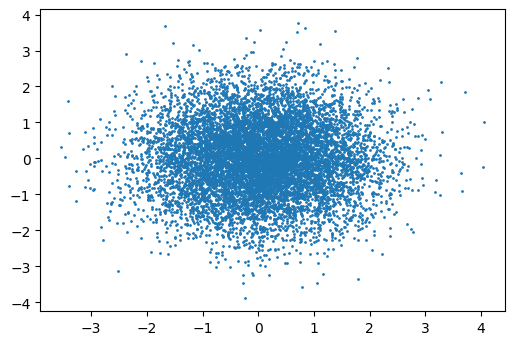

In [33]:
prior = np.random.standard_normal((10000, 2))
plt.scatter(prior[:, 0], prior[:, 1], s=1)